In [28]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor # genellikle resimlerin daha iyi eğitilmesi için transform işlemlerinin yapılması gerekir
# bu modul bunun için kullanılır.
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [29]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

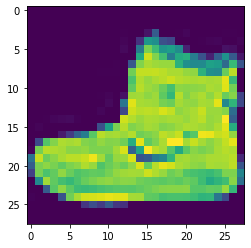

In [30]:
image, label=train_data[0]
plt.imshow(image.squeeze())  # cmap ile renk haritasını ayarlayın

In [31]:
# How many samples are there? 
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)
# See classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

train ve test data seti için DataLoader oluşturuyoruz.

In [32]:
train_data_loader=DataLoader(train_data,batch_size=32,shuffle=True)
test_data_loader=DataLoader(test_data,batch_size=32,shuffle=False)


In [33]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_data_loader))
train_features_batch.shape, train_labels_batch.shape
# size değişkeninin ilk değeri olan batch size tensor shape inde yer alır. 

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Pullover


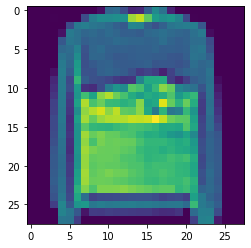

In [34]:
image_raw,label=train_features_batch[0],train_labels_batch[0]
plt.imshow(image_raw.squeeze())
print(class_names[label])

In [35]:
flatten_layer=nn.Flatten()
output=flatten_layer(image_raw)
output.shape

torch.Size([1, 784])

In [36]:
class FashionModel(nn.Module):
    def __init__(self):
        super(FashionModel,self).__init__()
        input_shape=28*28
        output_shape=10
        hidden_unit=10
        self.layers=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_unit),
            nn.Linear(in_features=hidden_unit,out_features=output_shape)
        )
    def forward(self,x):
        return self.layers(x)

In [37]:
model_0=FashionModel()
model_0.to("cuda")

FashionModel(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

optimizar ve Loss function belirlenmesi

In [38]:
optim=torch.optim.Adam(params=model_0.parameters(),lr=0.1)

loss_func=torch.nn.CrossEntropyLoss()

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [39]:
epochs=3

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    for batch,(X,y) in enumerate(train_data_loader):
        model_0.train() # modeli train moda aldık

        X, y = X.to("cuda"), y.to("cuda")# tüm inputların aynı device üzerinde olması gerekiyor.
        

        y_pred=model_0(X)# modelin bir tahmin yapmasını istiyoruz.

        loss=loss_func(y_pred,y)
        train_loss+= loss

        optim.zero_grad()# eğitim sürecinde türevlerin birikmesini engeller.
        loss.backward()# back propagation yapar.
        optim.step()# hesaplanan gradientlerin sonucunda modelim parametrelerini günceller.
        
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_data_loader.dataset)} samples")
        
    
    model_0.eval()# modeli evaluate durumuna aldık. burada modelin performansını değerlendireceğiz.
    
    train_loss /= len(train_data_loader)

    with torch.inference_mode():# sadece forward propagation yapar. gradiant hesaplanmaz
        test_loss,test_accurancy,test_acc=0,0,0
        for X,y in test_data_loader:
            X, y = X.to("cuda"), y.to("cuda")
            test_pred=model_0(X)
            test_loss=loss_func(test_pred,y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(test_data_loader)
        test_acc /= len(test_data_loader)

    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 3.23833 | Test loss: 0.00179, Test acc: 77.78%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 3.60712 | Test loss: 0.01032, Test acc: 66.47%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 3.54872 | Test loss: 0.00161, Test acc: 71.41%



In [40]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = "cuda"):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [41]:
# Calculate model 1 results with device-agnostic code 
model_1_results = eval_model(model=model_0, data_loader=test_data_loader,
    loss_fn=loss_func, accuracy_fn=accuracy_fn,
    device="cuda"
)
model_1_results

{'model_name': 'FashionModel',
 'model_loss': 3.684840440750122,
 'model_acc': 71.40575079872204}